# Tutorial for batch processing in `expsolve`

We illustrate this with `expsolve.fourier`, which is imported as `ex`.

Batch processing is built-in in `expsolve` from ground up. This notebook demonstrates how to use it in practice.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import expsolve as es
import expsolve.discretize.tensorgrid as ex
import expsolve.evolve.splittings.classical as split

import torch
from torch import exp, sin, cos, abs, real, imag, pi
from torch.linalg import matrix_exp

from IPython.display import display, Markdown

c:\ProgramData\Anaconda3\envs\torchcomplex\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda')

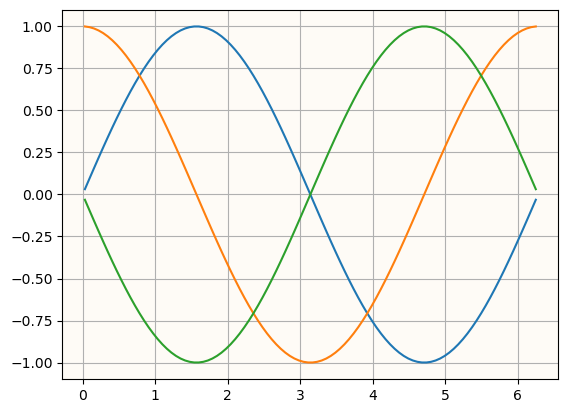

torch.Size([1, 100])
torch.Size([1, 100])


In [3]:
xrange = [0, 2*np.pi]
n = 100
x = ex.grid1d(n, xrange).to(device)     # this ensures everything ends up on the appropriate device!
s = sin(x)
ds = real(ex.diffop(0,1,s,xrange))
d2s = real(ex.diffop(0,2,s,xrange))

fig, ax = plt.subplots()
ex.plot(ax, x, s)
ex.plot(ax, x, ds)
ex.plot(ax, x, d2s)
plt.show()

print(s.shape)
print(ds.shape)

torch.Size([4, 100])
torch.Size([4, 100])


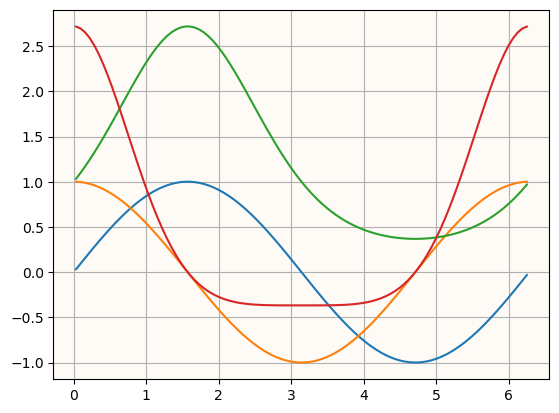

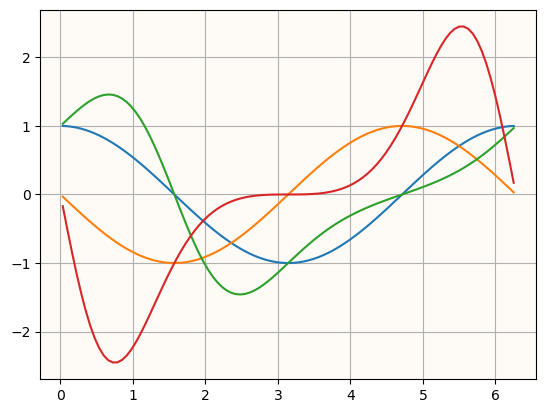

In [4]:
fns = [sin, cos, lambda x: exp(sin(x)), lambda x: cos(x)*exp(cos(x))]
f = torch.stack([f(x).flatten() for f in fns])
print(f.shape)


fig, ax = plt.subplots()
ex.plot(ax, x, f, separatelines=True)

df = real(ex.diffop(0,1,f,xrange))
d2f = real(ex.diffop(0,2,f,xrange))
print(df.shape)

fig, ax = plt.subplots()
ex.plot(ax, x, df, separatelines=True)
plt.show()

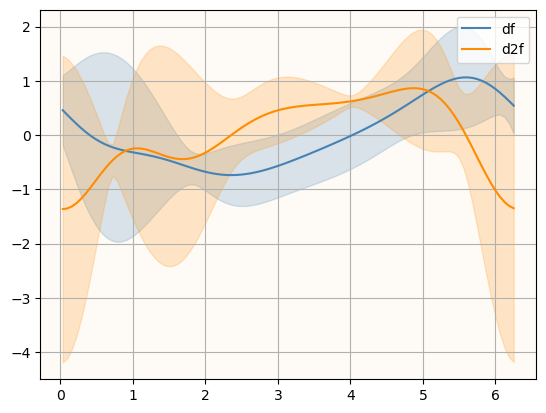

In [5]:
fig, ax = plt.subplots()
ex.plot(ax, linespecs=[((x,df),{'color':mcolors.CSS4_COLORS['steelblue']},'df'),
                            ((x,d2f),{'color':mcolors.CSS4_COLORS['darkorange']},'d2f')], 
                            separatelines=False)
plt.show()

### Randomized functions

torch.Size([3, 100])


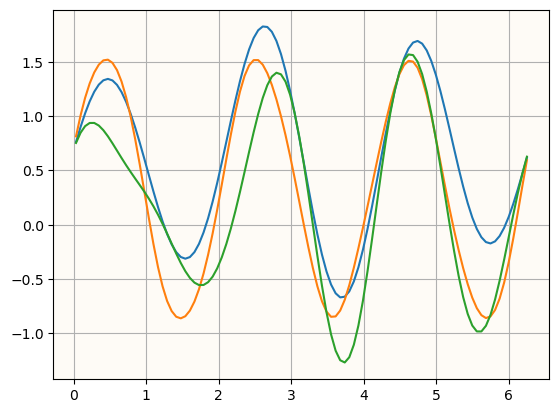

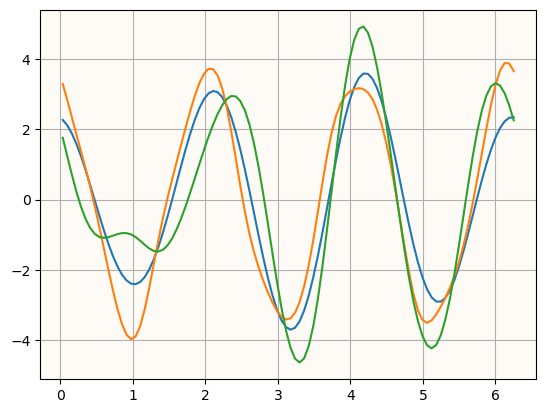

In [6]:
N = 3

# random, periodic functions
def randomf():
    # q real, p int
    p = np.random.randint(low=-5, high=5, size=4)
    q = np.random.normal(loc=0.2, scale=0.1, size=5)
    return sin(3*x) + q[0]*sin(p[0]*x) + q[1]*exp(q[2]*sin(p[1]*x)) + q[3]*cos(p[2]*x)*exp(q[4]*cos(p[3]*x))

fr = torch.stack([randomf().flatten() for _ in range(N)])


fig, ax = plt.subplots()
ex.plot(ax, x, fr, separatelines=True)
dfr = real(ex.diffop(0,1,fr,xrange))
print(dfr.shape)

fig, ax = plt.subplots()
ex.plot(ax, x, dfr, separatelines=True)
plt.show()


### Advantage of batch parallelization

In [7]:
N = 10000
frlist = [randomf() for _ in range(N)]
frtensor = torch.stack([fr.flatten() for fr in frlist])

tim1 = time.time()
dfrtensor = real(ex.diffop(0,1,frtensor,xrange))
tim2 = time.time()
tim_batch = tim2-tim1
print(f'Batch of size {N} took {tim_batch}s')


tim1 = time.time()
for fr in frlist:
    dfr = real(ex.diffop(0,1,fr,xrange))
tim2 = time.time()
tim_loop = tim2-tim1
print(f'Loop of size {N} took {tim_loop}s')

print(f'Speed up factor {tim_loop/tim_batch:.2f} on {device}')


KeyboardInterrupt: 

## Batch visualization

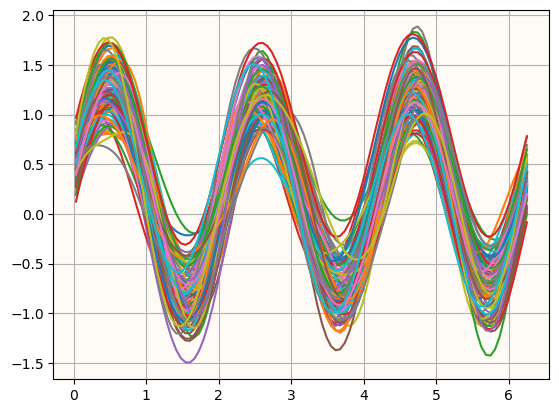

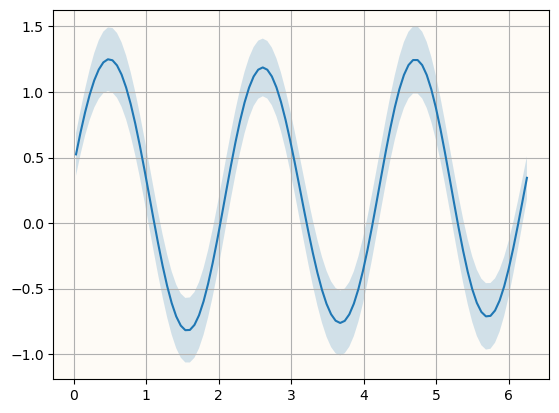

In [ ]:
N = 100
frlist = [randomf() for _ in range(N)]
frtensor = torch.stack([fr.flatten() for fr in frlist]) 

fig, ax = plt.subplots()
ex.plot(ax, x, frtensor, separatelines=True)
plt.show()

fig, ax = plt.subplots()
ex.plot(ax, x, frtensor)
plt.show()

## Solving the Schrodinger equation, when initial conditions are in a batch

### Creating and visualizing a random batch of initial conditions

In [ ]:
n = 200
L = 10
xr = [-L, L]
x = ex.grid1d(n, xr).to(device)

V = x**4 - 10*x**2

def ugen(sx0, svar, sw0):
    x0 = np.random.normal(loc=0, scale=sx0)
    var = 0.1 + np.random.normal(loc=0, scale=svar)**2
    w0 = np.random.normal(loc=0, scale=sw0)

    u = exp(-(x-x0)**2/(2*var))*exp(1j*pi*w0*(x-x0))    
    u = ex.normalize(u, xr)
    return u


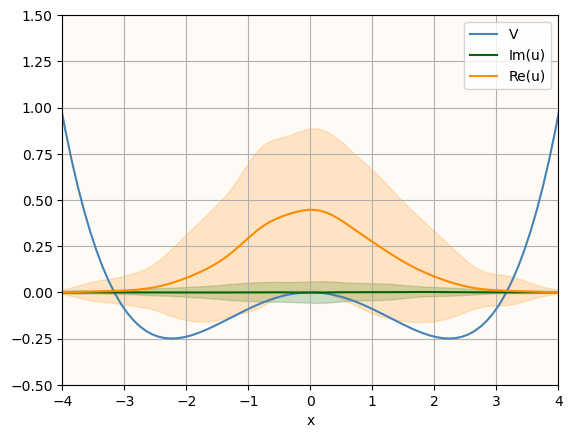

In [ ]:
N = 1000
urlist = [ugen(sx0=1.0, svar=0.3, sw0=0.1) for _ in range(N)]
urtensor = torch.stack([ur.flatten() for ur in urlist]) 

lines = lambda u: [((x, V/100), {'color':mcolors.CSS4_COLORS['steelblue']}, 'V'), 
                       ((x, imag(u)), {'color':mcolors.CSS4_COLORS['darkgreen']}, 'Im(u)'),
                       ((x, real(u)), {'color':mcolors.CSS4_COLORS['darkorange']}, 'Re(u)')]

fig, ax = plt.subplots()
ex.plot(ax, linespecs=lines(urtensor), xlim=[-4,4], ylim=[-0.5,1.5], xlabel='x')
plt.show()


Verifying that all initial conditions have norm 1.

Demonstrating l2norm on a batch

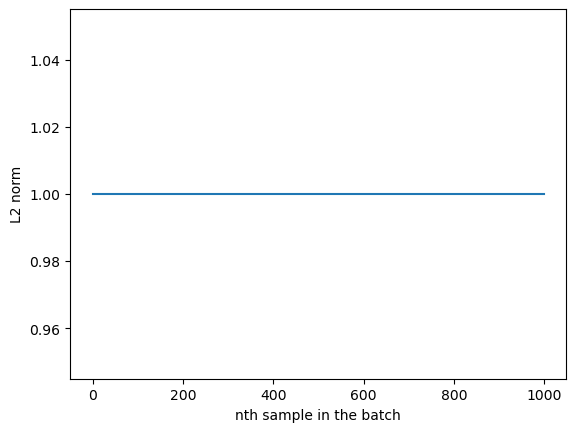

In [ ]:
plt.plot(ex.l2norm(urtensor, xr).cpu())
plt.ylabel('L2 norm')
plt.xlabel('nth sample in the batch')
plt.show()

In [ ]:
#v = V.to(device)
eLu = lambda t, h, c, u: ex.diffopexp(0, 2, 1j*c*h, u, xr)
eVu = lambda t, h, c, u: exp(-1j*c*h*V)*u

strangalpha, strangbeta = split.symmetric([],[])
print(strangalpha, strangbeta)

strangstep = lambda t, h, u0: split.stepper(t, h, u0, eVu, eLu, strangalpha, strangbeta)

tensor([0.5000, 0.5000], dtype=torch.float64) tensor([1., 0.], dtype=torch.float64)


In [ ]:
T = 1.

tim1 = time.time()
uTbatch = es.solvediffeq(urtensor, es.timegrid([0,T], 10), strangstep)[0]
tim2 = time.time()
tim_batch = tim2-tim1
print(f'Batch of size {N} took {tim_batch}s')


tim1 = time.time()
for ur in urlist:
    ustrangTloop = es.solvediffeq(ur, es.timegrid([0, T], 10), strangstep)[0]
tim2 = time.time()
tim_loop = tim2-tim1
print(f'Loop of size {N} took {tim_loop}s')

print(f'Speed up factor {tim_loop/tim_batch:.2f} on {device}')

Batch of size 1000 took 0.05601358413696289s


Loop of size 1000 took 16.986680030822754s
Speed up factor 303.26 on cuda


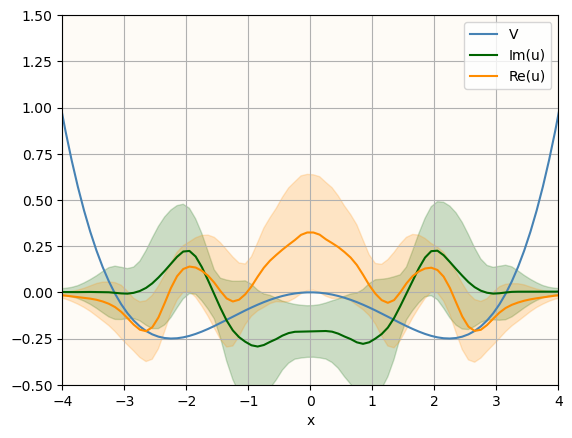

In [ ]:
fig, ax = plt.subplots()
ex.plot(ax, linespecs=lines(uTbatch), xlim=[-4,4], ylim=[-0.5,1.5], xlabel='x')
plt.show()

### Observables

In [16]:
Nstep = 100
timegrid = es.timegrid([0,T], Nstep)

observables = {'energy': lambda u, t: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr) + V*psi, u, xr), 
'position': lambda u, t: ex.observable(lambda psi: x*psi, u, xr), 
'momentum': lambda u, t: ex.observable(lambda psi: 1j*ex.diffop(0, 1, psi, xr), u, xr), 
'kinetic': lambda u, t: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr), u, xr), 
'potential':lambda u, t: ex.observable(lambda psi: V*psi, u, xr)}

uTbatch, obsvalues_batch, uintermediate_batch = es.solvediffeq(urtensor, timegrid, strangstep, observables=observables, storeintermediate=True)

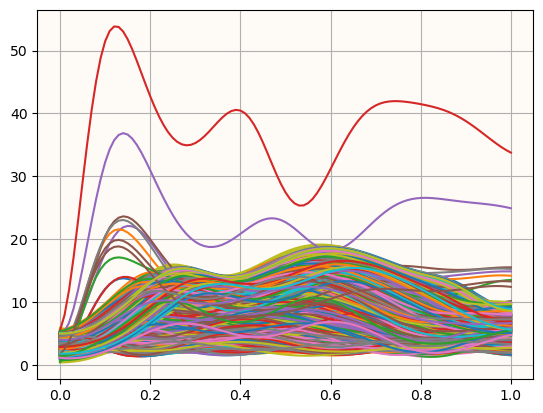

In [17]:
fig, ax = plt.subplots()
ex.plot(ax, timegrid, obsvalues_batch['kinetic'], separatelines=True)
plt.show()

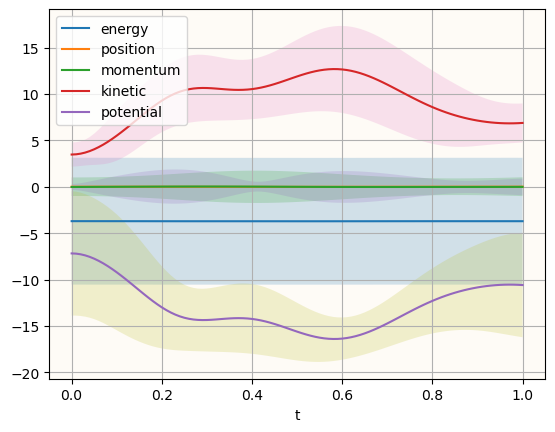

In [18]:
ex.obsplot(plt, timegrid, obsvalues_batch)

### Animate

In [19]:
linesatframe = lambda index: [((x, V/100), {'color':mcolors.CSS4_COLORS['steelblue']}, 'V'), 
                       ((x, imag(uintermediate_batch[index])), {'color':mcolors.CSS4_COLORS['darkgreen']}, 'Im(u)'),
                       ((x, real(uintermediate_batch[index])), {'color':mcolors.CSS4_COLORS['darkorange']}, 'Re(u)')]

drawframe = lambda ax, frame: ex.plot(ax, linespecs=linesatframe(frame),  xlim=[-4,4], ylim=[-0.5,1.5], xlabel='x')
outputgif = 'batch.gif'
es.animate(drawframe, len(uintermediate_batch), outputgif, speedfactor=1, border=True)

In [20]:
display(Markdown(f'![gif]({outputgif})'))

![gif](batch.gif)

### Computing matrix vector products - for brute force solution, for example

In [21]:
N = 1000
urlist = [ugen(sx0=1.0, svar=0.3, sw0=0.1) for _ in range(N)]
urtensor = torch.stack([ur.flatten() for ur in urlist]) 

D2 = ex.diffmatrix(2, n, xr).to(device)
H = -D2 + es.linalg.diag(V)

In [22]:
print(H.shape)
print(urtensor.shape)
print(es.linalg.matmul(H, urtensor).shape)

torch.Size([200, 200])
torch.Size([1000, 200])
torch.Size([1000, 200])


In [23]:
T = 1.

tim1 = time.time()
uTexpbatch = es.linalg.matmul(matrix_exp(-1j*T*H), urtensor)  
tim2 = time.time()
tim_batch = tim2-tim1
print(f'Batch of size {N} took {tim_batch}s')


tim1 = time.time()
for ur in urlist:
    uTexploop = es.linalg.matmul(matrix_exp(-1j*T*H), ur)  
tim2 = time.time()
tim_loop = tim2-tim1
print(f'Loop of size {N} took {tim_loop}s')

print(f'Speed up factor {tim_loop/tim_batch:.2f} on {device}')

Batch of size 1000 took 0.5545542240142822s
Loop of size 1000 took 15.36894679069519s
Speed up factor 27.71 on cuda


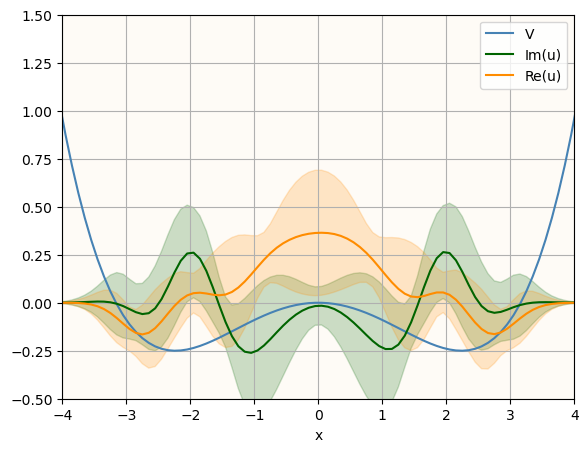

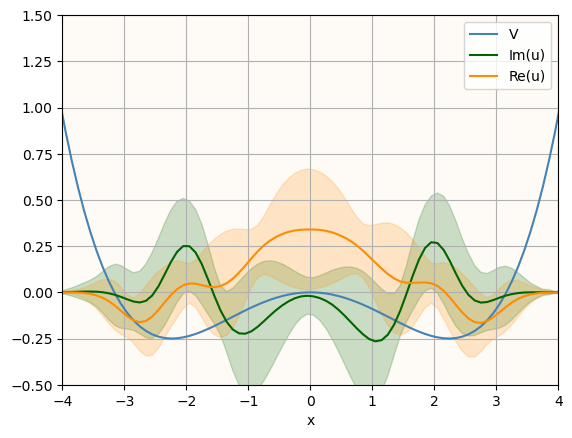

In [24]:
fig, ax = plt.subplots()
ex.plot(ax, linespecs=lines(uTexpbatch), xlim=[-4,4], ylim=[-0.5,1.5], xlabel='x')
plt.show()

### 2D example

We *need* to test this too!

In [23]:
n = [50, 50]
xr = [-10, 10]
[x,y] = ex.grid(n, xr)

V = x**4 + y**4 - 5*x**2 - 5*y**2

def ugen2D(sx0, svar, sw0):
    x0 = np.random.normal(loc=0, scale=sx0)
    y0 = np.random.normal(loc=0, scale=sx0)
    var = 0.1 + np.random.normal(loc=0, scale=svar)**2
    w0x = np.random.normal(loc=0, scale=sw0)
    w0y = np.random.normal(loc=0, scale=sw0)

    u = exp(-((x-x0)**2 + (y-y0)**2)/(2*var)) * exp(1j*pi*w0x*(x-x0)) * exp(1j*pi*w0y*(y-y0))    
    u = ex.normalize(u, xr)
    return u

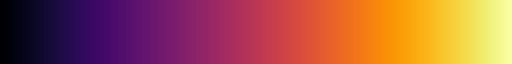

In [24]:
import matplotlib as mpl
mpl.colormaps['inferno']

In [25]:
additivespecs = lambda u: [(xr, imag(u), mpl.colormaps['Blues'], 10.0*abs(imag(u)), 'bicubic'),
                           (xr, real(u), mpl.colormaps['Oranges'], 10.0*abs(real(u)), 'bicubic')]

phasespecs = lambda u: [(xr, es.utils.phasescaled(u), mpl.colormaps['RdYlBu'], 10.0*abs(u), 'bicubic')]

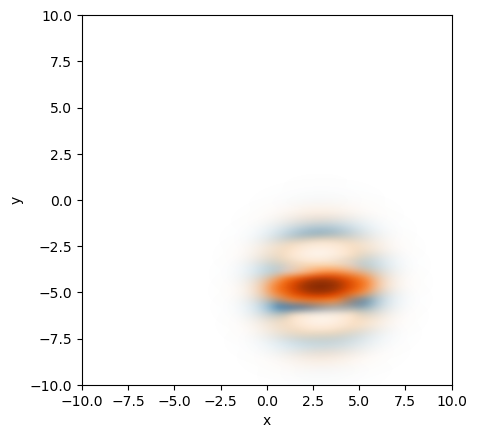

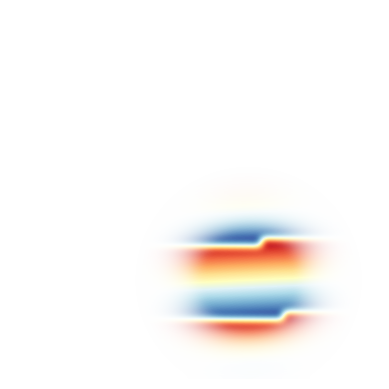

In [35]:
u0 = ugen2D(sx0=3.0, svar=2.0, sw0=1.0)
fig, ax = plt.subplots()
ex.imshow(ax, imspecs=additivespecs(u0))
plt.show()

fig, ax = plt.subplots()
ex.imshow(ax, imspecs=phasespecs(u0))
plt.show()

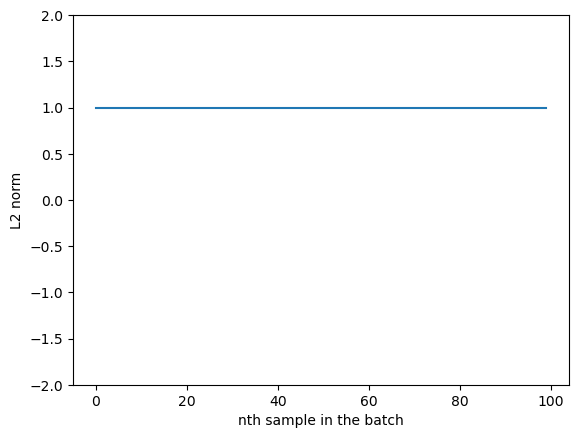

In [36]:
N = 100
urlist = [ugen2D(sx0=3.0, svar=2.0, sw0=1.0).squeeze(dim=0) for _ in range(N)]
urtensor = torch.stack(urlist) 

plt.plot(ex.l2norm(urtensor, xr).cpu())
plt.ylabel('L2 norm')
plt.xlabel('nth sample in the batch')
plt.ylim([-2,2])
plt.show()

In [37]:
#v = V.to(device)
eL1u = lambda h, c, u: ex.diffopexp(0, 2, 1j*h, u, xr) 
eL2u = lambda h, c, u: ex.diffopexp(1, 2, 1j*h, u, xr)

eLu = lambda t, h, c, u: eL1u(h, c, eL2u(h, c, u)) 
eVu = lambda t, h, c, u: exp(-1j*c*h*V)*u

strangalpha, strangbeta = split.symmetric([],[])
print(strangalpha, strangbeta)

strangstep = lambda t, h, u0: split.stepper(t, h, u0, eVu, eLu, strangalpha, strangbeta)

tensor([0.5000, 0.5000], dtype=torch.float64) tensor([1., 0.], dtype=torch.float64)


In [40]:
T = 1.
Nstep = 200
timegrid = es.timegrid([0,T], Nstep)

observables = {'energy': lambda u, t: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr) -ex.diffop(1, 2, psi, xr) + V*psi, u, xr), 
'position x': lambda u, t: ex.observable(lambda psi: x*psi, u, xr), 
'position y': lambda u, t: ex.observable(lambda psi: y*psi, u, xr), 
'momentum x': lambda u, t: ex.observable(lambda psi: 1j*ex.diffop(0, 1, psi, xr), u, xr), 
'momentum y': lambda u, t: ex.observable(lambda psi: 1j*ex.diffop(1, 1, psi, xr), u, xr), 
'kinetic': lambda u, t: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr) -ex.diffop(1, 2, psi, xr), u, xr), 
'potential':lambda u, t: ex.observable(lambda psi: V*psi, u, xr)}

In [41]:
T = 1.

tim1 = time.time()
uTbatch, obsvalues_batch, uintermediate_batch = es.solvediffeq(urtensor, timegrid, strangstep, observables=observables)
tim2 = time.time()
tim_batch = tim2-tim1
print(f'Batch of size {N} took {tim_batch}s')


tim1 = time.time()
for ur in urlist:
    ustrangTloop = es.solvediffeq(ur.unsqueeze(dim=0), timegrid, strangstep, observables=observables)[0]
tim2 = time.time()
tim_loop = tim2-tim1
print(f'Loop of size {N} took {tim_loop}s')

print(f'Speed up factor {tim_loop/tim_batch:.2f} on {device}')

Batch of size 100 took 41.949527740478516s


KeyboardInterrupt: 

Speedup is expected to be more when each problem itself is small, and the number of batches large. For high dimensional problems, this reduces the speedup from batch operations. The exact level at which speedup becomes limited depends on the CPU/GPU architecture heavily, of course.

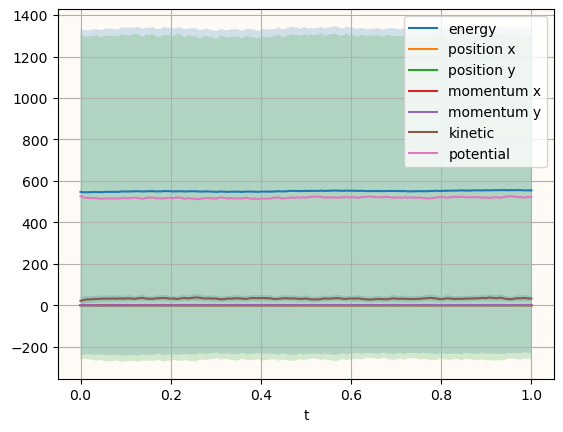

In [ ]:
ex.obsplot(plt, timegrid, obsvalues_batch)